In [11]:
%pip install --quiet tqdm

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma, norm, invgamma
from tqdm import tqdm

In [13]:
from scipy.stats import gamma as gamma_dist
from scipy.stats import expon

from src.mixtures.nmv_mixture import NormalMeanVarianceMixtures
from src.generators.nmv_generator import NMVGenerator
from src.estimators.semiparametric.nmv_semiparametric_estimator import NMVSemiParametricEstimator

In [14]:
def calculate_metrics(estimates, true_values):
    """
    Calculate MSE, MAE, and Relative Error.
    """
    mse = np.mean((estimates - true_values) ** 2)
    mae = np.mean(np.abs(estimates - true_values))
    relative_error = np.mean(np.abs(estimates - true_values) / (true_values + 1e-10))
    return mse, mae, relative_error

def plot_comparison(x_values, estimates1, estimates2, true_density, title):
    """
    Plot comparison of two algorithms.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x_values, estimates1, 'bo-', label='Mellin')
    plt.plot(x_values[6:], estimates2[6:], 'go-', label='PostWidder')
    plt.plot(x_values, true_density(x_values), 'r--', label='True Density')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
from src.estimators.semiparametric.nmv_semiparametric_estimator import NMVSemiParametricEstimator
mu = 0.5

mixture = NormalMeanVarianceMixtures("canonical", alpha=0, mu=mu, distribution=expon)
generator = NMVGenerator()
sample = generator.canonical_generate(mixture, 10000)

x_values = np.linspace(0.1, 3, 20)
estimator_given_mu = NMVSemiParametricEstimator(
        "g_estimation_given_mu", {"x_data": x_values, "u_value": 7.6, "v_value": 0.9, "mu": mu, "grid_size": 200}
)
estimator_post_widder = NMVSemiParametricEstimator(
        "g_estimation_post_widder", {"x_data": x_values, "sigma": 1, "n": 2, "mu": mu}
)

result_given_mu = estimator_given_mu.estimate(sample)
result_post_widder = estimator_post_widder.estimate(sample)

result_post_widder_float = [float(val) for val in result_post_widder.list_value]

Mellin:
  MSE: 0.0042, MAE: 0.0557, Relative Error: 0.5261
PostWidder:
  MSE: 0.0541, MAE: 0.1358, Relative Error: 0.5415


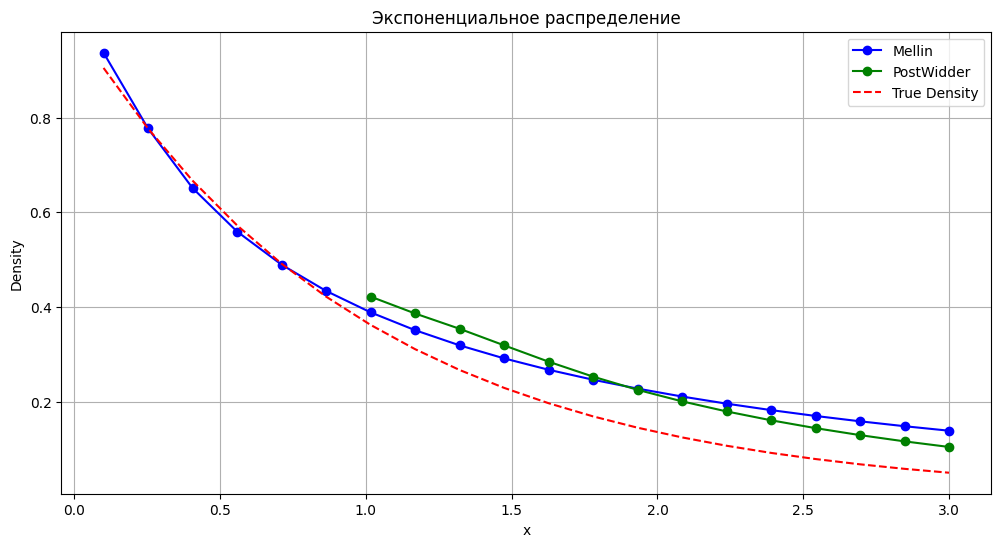

In [16]:
# Calculate metrics
mse_given_mu, mae_given_mu, rel_given_mu = calculate_metrics(result_given_mu.list_value, expon.pdf(x_values))
mse_post_widder, mae_post_widder, rel_post_widder = calculate_metrics(result_post_widder_float, expon.pdf(x_values))

print("Mellin:")
print(f"  MSE: {mse_given_mu:.4f}, MAE: {mae_given_mu:.4f}, Relative Error: {rel_given_mu:.4f}")
print("PostWidder:")
print(f"  MSE: {mse_post_widder:.4f}, MAE: {mae_post_widder:.4f}, Relative Error: {rel_post_widder:.4f}")

# Visualize results
plot_comparison(x_values, result_given_mu.list_value, result_post_widder_float, expon.pdf,
               "Экспоненциальное распределение")

In [17]:
from numpy import trapz

def calculate_metrics_i(x_grid: np.ndarray, pdf_true: np.ndarray, pdf_est: np.ndarray):
    metrics = {}
    dx = x_grid[1] - x_grid[0]
    pdf_diff_sq = (pdf_true - pdf_est)**2
    pdf_diff_abs = np.abs(pdf_true - pdf_est)

    metrics['ISE'] = trapz(pdf_diff_sq, x_grid)
    metrics['IAE'] = trapz(pdf_diff_abs, x_grid)

    return metrics

In [18]:
calculate_metrics_i(x_values[6:], expon.pdf(x_values[6:]), result_post_widder_float[6:])

{'ISE': 0.011139990821438803, 'IAE': 0.14708044839102255}